In [4]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

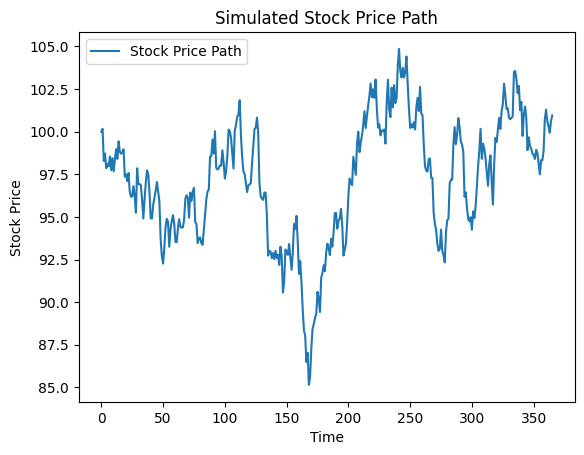

In [18]:
def get_stock_prices_via_EM(s:float, sigma:float, T:float, dt:float, N:int) -> np.array:
    """ Simulate Stock Price SDE of dS_u = sigma * dW_u via the Euler Maruyama method

    Args:
        s (float): Initial stock price
        sigma (float): Volatility
        T (float): Time Horizon
        dt (float): Time Steps
        N (int): Number of Time Steps

    Returns:
        np.array: Stock Prices
    """
    S = np.zeros(N + 1) # Initialize the Stock Price Array
    S[0] = s # First Stock Price
    dW = np.random.normal(0, np.sqrt(dt), N) # GBM increments
    for t in range(1, N+1):
        S[t] = S[t-1] + sigma*dW[t-1] # Simulate Stock Prices via the Euler Maruyama Method
    return S

s = 100 # First Price
sigma = 1 # Volatiltiy
T = 365 # Time Horizon
dt = 1 # Time Steps
N = int(T/dt) # Calculate number of Time Steps
S = get_stock_prices_via_EM(s=s, sigma=sigma, T=T, dt=dt, N=N)

# Plot the simulated stock price path
plt.plot(np.linspace(0, T, N+1), S, label='Stock Price Path')
plt.title('Simulated Stock Price Path')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()